<a href="https://colab.research.google.com/github/ospinooo/mushsnap-research/blob/master/PyTorch_FastAI_RESNET_MushSnap_Image_Classification_FineTunning_Augmentation_Kaggle_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Which GPU?
!nvidia-smi

Fri Jun 12 14:38:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Activate the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Installing other version because of unnecessary warnings
!pip install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install "Pillow<7"

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 748.9MB 14kB/s 
     |████████████████████████████████| 8.8MB 42.6MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 2.1MB 14.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
import torch
import torchvision
print(torchvision.__version__)
print(torch.__version__)

0.4.0
1.2.0


In [ ]:
from subprocess import check_output
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import time
import os

from fastai.callbacks import ActivationStats
from fastai.callbacks import SaveModelCallback

from fastai.vision import cnn_learner
from fastai.vision import ImageDataBunch
from fastai.vision import Path
from fastai.vision import get_transforms
from fastai.vision import imagenet_stats
from fastai.vision import models
from fastai.vision import accuracy
from fastai.vision import ClassificationInterpretation


from fastai.metrics import error_rate, FBeta
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random
import shutil
import time
import cv2
import os

## Dataset Configuration

In [ ]:
# Set variables
ZIP_FILENAME_DATASET="mushsnap_dataset_2020-04-20_11-04-43.tar.gz"
DRIVE_PATH= "drive/My Drive/"
TFG_PATH= DRIVE_PATH + "final project"
data_root = "data/data"

### Dataset

In [ ]:
# Decompress
!tar -xf drive/'My Drive'/'final project'/dataset/$ZIP_FILENAME_DATASET

In [ ]:
# Reading all paths
NUM_MIN = min(len(list(paths.list_images("dataset/edible"))), len(list(paths.list_images("dataset/poisonous"))))
ALL_IMG_PATHS = list(paths.list_images("dataset/edible"))[:NUM_MIN] + list(paths.list_images("dataset/poisonous"))[:NUM_MIN]
ALL_IMG_PATHS = [i for i in ALL_IMG_PATHS if i.split("/")[2][0] != '.']
# Shuffle image paths and preview
random.seed(1)
random.shuffle(ALL_IMG_PATHS)
print(ALL_IMG_PATHS[:5])
print(f" Total number of images: {len(ALL_IMG_PATHS)}")

['dataset/edible/19963586598_9b6d1f9d96_n.jpg', 'dataset/edible/48840214828_448d1dffb3_n.jpg', 'dataset/edible/3742746266_dcdfab10a1_n.jpg', 'dataset/edible/27300067386_d64a81f864_n.jpg', 'dataset/poisonous/10061499526_54cebac664_n.jpg']
 Total number of images: 10731


In [ ]:
# Visualize images
plt.figure(figsize=(30,15))
for i in tqdm(range(50)):
    image_path = np.random.choice(ALL_IMG_PATHS)
    image = plt.imread(image_path)
    image = cv2.resize(image, (128, 128))
    # you might want to verify the labels before 
    # you put this to use
    label = image_path.split("/")[1]
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image)
    plt.xlabel(label)
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [ ]:
path = Path('dataset')
dest = path
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(
    path, 
    train='.', 
    valid_pct=0.35, 
    ds_tfms=get_transforms(),
    size=224, 
    num_workers=4
).normalize(imagenet_stats)

In [ ]:
data

ImageDataBunch;

Train: LabelList (7823 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
edible,edible,edible,edible,edible
Path: dataset;

Valid: LabelList (4211 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
poisonous,poisonous,poisonous,edible,poisonous
Path: dataset;

Test: None

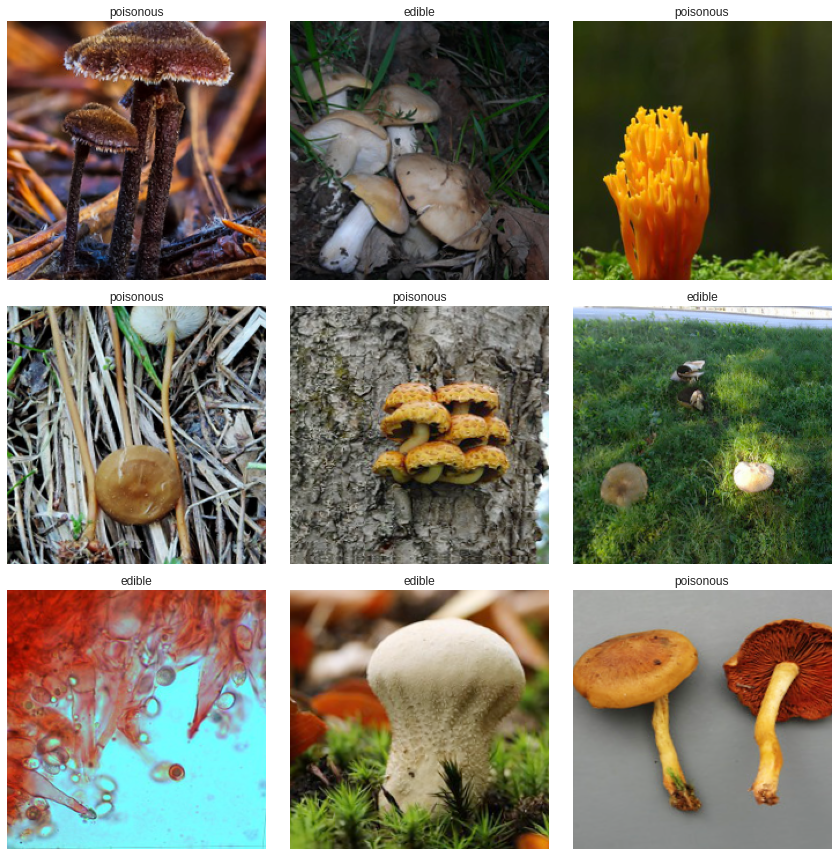

In [ ]:
data.show_batch(rows=3)

In [ ]:
print("Classes", data.classes)
print("Number of classes: ", data.c)
print("Train dataset size: ", len(data.train_ds))
print("Validation dataset size: ", len(data.valid_ds))

Classes ['edible', 'poisonous']
Number of classes:  2
Train dataset size:  7823
Validation dataset size:  4211


## Training

In [ ]:
# Transfer learning from models available in Fastai
learn = cnn_learner(
    data, # DataBunch
    models.resnet50, # Transfer learning
    metrics=[accuracy, FBeta(average='macro')], # Metrics
    model_dir= os.path.join(TFG_PATH, "models", "fastai")
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 56.0MB/s]


In [ ]:
# Solve error of loading truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
learn.fit_one_cycle(
    8,  # Cycle Len (Number of Epochs)
    wd=0.9
)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.058389,0.834016,0.644265,0.639080,01:45
1,0.698931,0.597031,0.676086,0.670118,01:45
2,0.605948,0.579719,0.697222,0.689249,01:45
3,0.553346,0.563734,0.706008,0.691705,01:46
4,0.532995,0.546289,0.717169,0.707938,01:46
5,0.499932,0.533083,0.724768,0.721218,01:46
6,0.450486,0.514448,0.739967,0.735216,01:47
7,0.419942,0.510278,0.741629,0.735914,01:47


In [ ]:
learn.unfreeze()

Let's find the optimum learning rate using learning rate finder. The plot shows that the steepest decrease in the loss value happens when learning rate is around 1e-03 value.

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


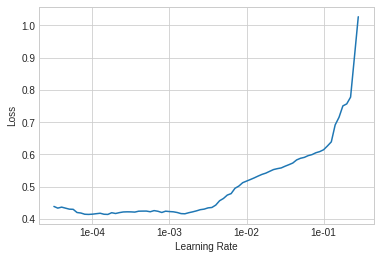

In [ ]:
# Range test tool
learn.lr_find(start_lr = slice(1e-5), end_lr=slice(1))
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(
    4, 
    max_lr=slice(1e-5, 2e-3), # Cycle maximum learning rate
    pct_start=0.8, 
    wd=0.9, # Weight decay - penalize complexity
    callbacks=[SaveModelCallback(
                   learn, 
                   every='improvement', 
                   monitor='accuracy', 
                   name='model_best')]
  )

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.429559,0.498475,0.755877,0.752774,02:01
1,0.437484,0.535022,0.734505,0.736704,02:02
2,0.427029,0.524259,0.754690,0.746876,02:02
3,0.328669,0.478191,0.784612,0.783545,02:02


Better model found at epoch 0 with accuracy value: 0.7558774352073669.
Better model found at epoch 3 with accuracy value: 0.784611701965332.


In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


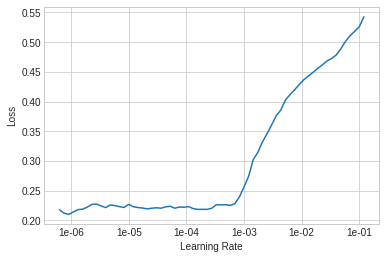

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
os.path.join(TFG_PATH, "models", "fastai")

'drive/My Drive/final project/models/fastai'

In [ ]:
learn.fit_one_cycle(15, max_lr=1e-04, pct_start=0.8, wd=0.9, 
                    callbacks=[SaveModelCallback(
                                      learn, 
                                      every='improvement', 
                                      monitor='accuracy', 
                                      name='model_best')])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.205287,0.468666,0.789836,0.788426,02:00
1,0.180522,0.467870,0.793873,0.792896,02:01
2,0.158034,0.481338,0.789599,0.788398,02:01
3,0.132748,0.502947,0.795536,0.792877,02:02
4,0.107378,0.552328,0.793636,0.791506,02:01
5,0.109585,0.575724,0.788649,0.787310,02:01
6,0.115905,0.625943,0.770601,0.768945,02:02
7,0.129413,0.629225,0.775113,0.773744,02:02
8,0.132765,0.648902,0.776775,0.775437,02:02
9,0.137907,0.671145,0.771313,0.773113,02:02


Better model found at epoch 0 with accuracy value: 0.7898361682891846.
Better model found at epoch 1 with accuracy value: 0.7938731908798218.
Better model found at epoch 3 with accuracy value: 0.7955355048179626.
Better model found at epoch 13 with accuracy value: 0.8014723062515259.
Better model found at epoch 14 with accuracy value: 0.8074091672897339.


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

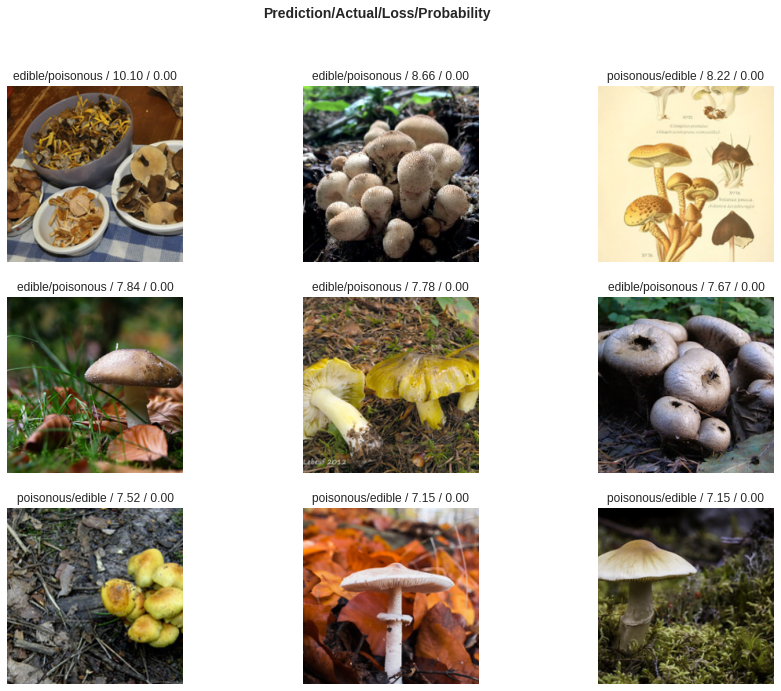

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

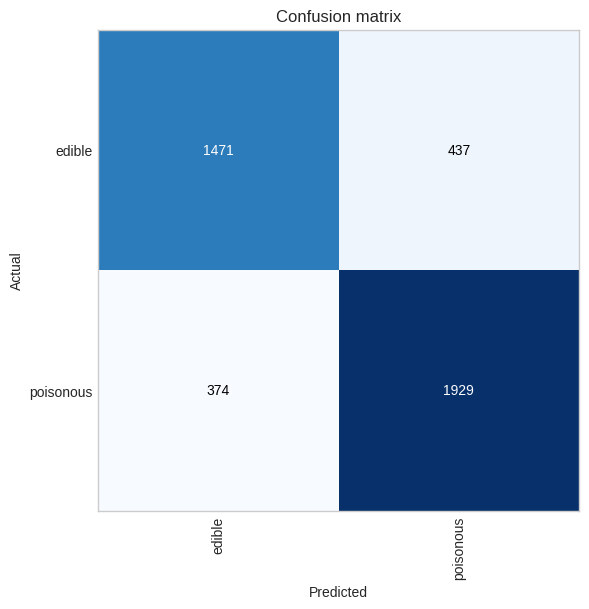

In [ ]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)

In [ ]:
preds_test, y_test, losses_test= learn.get_preds(ds_type=data.valid_ds, with_loss=True)

In [ ]:
acc = accuracy(preds_test,y_test).item()
print("Accuracy on test set: ", acc)

Accuracy on test set:  0.9991052150726318


## Export

In [ ]:
learn.export(os.path.join("..", TFG_PATH, f'models/fastai/trained_model_{int(acc*100)}.pth'))